# Solution for the first science case

In this section, we are visualizing astronomical data from an aperture-based observation, comparing observed and absolute magnitudes of stars. We will plot two graphs side by side, showing the g-i vs. g and the corresponding absolute magnitude corrected for distance modulus.

In [4]:
#########################################
# Author: Eduardo Alberto Duarte Lacerda
# E-mail: dhubax@gmail.com
#########################################

#########################################
# Adapted for XI LAPIS 2025
# by Felipe Almeida-Fernandes
# E-mail: felipe.fernandes@inpe.br
#########################################

## SETUP

We may need to install a few packages (lsdb, splusdata, dask):

In [ ]:
# LSDB
!pip install lsdb

# splusdata
!pip install splusdata

# dask
!pip install dask

In [12]:
# imports for data retrieve
import lsdb
import splusdata
from dask.distributed import Client

# imports for plot and calculation
import numpy as np
from matplotlib import pyplot as plt

## Read catalogs using LSDB

### Start Dask client

In [7]:
# Start a Dask client for the parallel process used by lsdb
max_cpu = 8
max_mem = '6GB'
client = Client(n_workers=max_cpu, memory_limit=max_mem)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 24,Total memory: 44.70 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:32887,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 24
Started: Just now,Total memory: 44.70 GiB
Comm: tcp://127.0.0.1:34519,Total threads: 3
Dashboard: http://127.0.0.1:34653/status,Memory: 5.59 GiB
Nanny: tcp://127.0.0.1:40137,


## S-PLUS Catalog

### Finding the catalog

We will use splusdata to get the link to the catalogs

In [ ]:
# search for the full S-PLUS DR4/dual mode catalog
dr4psf_search = splusdata.get_hipscats('dr4/psf')

# Print all catalogs found with the pattern above
print(f'dr4/psf search: {dr4psf_search}')

# select the first catalog found
dr4psf_hipscat, dr4psf_margin_cache_hipscat = dr4psf_search[0]

dr4/psf search: [['https://splus.cloud/HIPS/catalogs/dr4/psf/', 'https://splus.cloud/HIPS/catalogs/dr4/psf_2arcsec/']]


### The 'margin' catalog

The psf_2arcsec is a lsdb 'margin' catalog. It is just a technical workaround for crossmatching catalogs that were initially broken down in smaller parts and is meant to avoid issues in the borders of this regions. Read more in 'https://docs.lsdb.io/en/stable/tutorials/margins.html'

### Selecting the columns

Obs: more information about the available columns can be found at https://splus.cloud/documentation/DR4?Schemas,_tables_and_columns

In [22]:

# Create the columns list to retrieve only necessaries columns

columns = ['ID', 'RA', 'DEC'] 

apperture = 'psf'

bands = ['g', 'r', 'i']

#######################
# Adding to the columns

columns += [f'{b}_{apperture}' for b in bands] 
columns += [f's2n_{b}_{apperture}' for b in bands]
columns += [f'CLASS_STAR_{b}' for b in bands]

### Preparing a filter to select only stars

We will use `CLASS_STAR`= 1 for all selected filters (ex. `CLASS_STAR_g`= 1 )

In [23]:
# Filter to select only stars 
filters = [(f'CLASS_STAR_{b}', '=', 1) for b in bands]


### Read the S-PLUS DR4/psf catalog

In [27]:
# Read more about the need of the margin cache server at:
#      https://lsdb.readthedocs.io/en/stable/tutorials/margins.html    
dr4psf_margin = lsdb.read_hats(dr4psf_margin_cache_hipscat)

# Read DR4 dual HiPSCAT
dr4psf = lsdb.read_hats(dr4psf_hipscat, 
                           margin_cache=dr4psf_margin,
                           columns=columns,
                           filters=filters)

TypeError: argument should be a str or an os.PathLike object where __fspath__ returns a str, not 'MarginCatalog'

## Reading Gaia DR3

In [ ]:
# GAIA DR3 HiPSCat
columns_gaia = ['source_id', 'ra', 'dec', 'parallax', 'parallax_error', 'pmra', 'pmdec']

gaia = lsdb.read_hipscat('https://data.lsdb.io/unstable/gaia_dr3/gaia/',
    margin_cache='https://data.lsdb.io/unstable/gaia_dr3/gaia_10arcs/',
    columns= columns_gaia)

## Perform the crossmatch

In [ ]:
dr4psfgaia_crosmatch = dr4psf.crossmatch(gaia, suffixes=['_dr4', '_gaia'], radius_arcsec=1)

### Visualizing the crossmatch

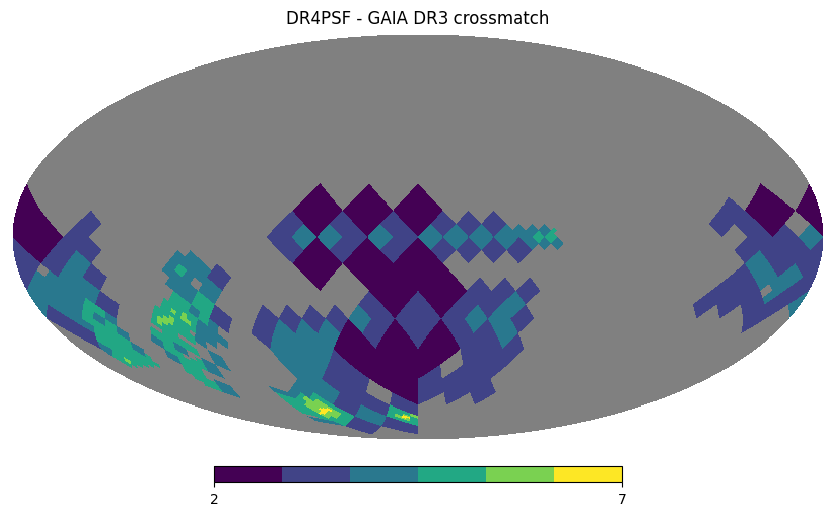

In [ ]:
dr4psfgaia_crosmatch.plot_pixels('DR4PSF - GAIA DR3 crossmatch')

## Cone search using the crossmatched table

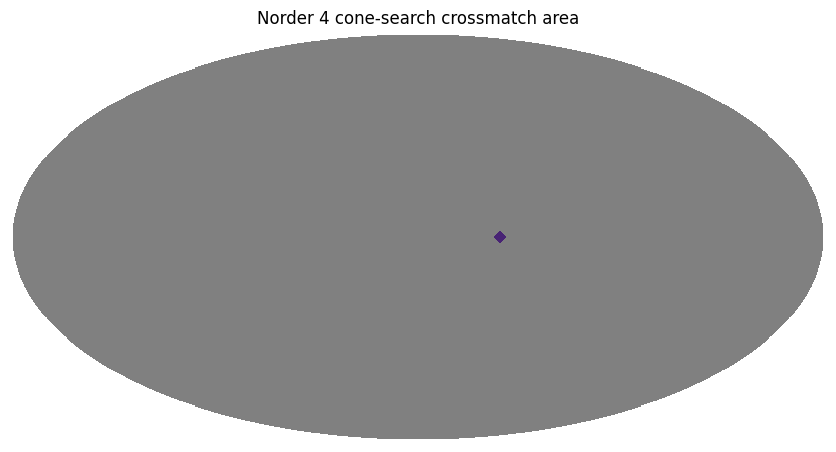

In [ ]:
# Let's get the resultant table:

# These are the coordinates of the Messier 2 Globular Cluster
RA0 = 323.36249 # Central RA in degrees
DE0 = -0.82333 # Central DE in degrees

cone_radius = 30*60 # arcsec (radius of our search around RA0 and DEC0)

objects_table_crossmatch = dr4psfgaia_crosmatch.cone_search(ra=RA0, 
                                                            dec=DE0, 
                                                            radius_arcsec=cone_radius)

#### Let's visualize the resulting table:


In [ ]:
objects_table_crossmatch.plot_pixels('cone-search crossmatch area')

In [ ]:
objects_table = objects_table_crossmatch.compute()

<hr>

## Create plots

###  Selection of objects

In [ ]:
# M2 Selection of pixels
# Messier 2 proper motion mask (cluster selection using GAIA DR3 proper motion)
pmra, pmdec = 3.5, -2.15  # Proper motion in mas/yr (milliarcseconds per year)
M2_distance_pc = 11500  # Distance to Messier 2 in parsecs

# Apply proper motion selection for Messier 2 based on GAIA DR3
M2_mask = objects_table['pmra_gaia'] > (pmra - 0.5)  # Lower bound of pmra
M2_mask = np.bitwise_and(M2_mask, objects_table['pmra_gaia'] < (pmra + 0.5))  # Upper bound of pmra
M2_mask = np.bitwise_and(M2_mask, objects_table['pmdec_gaia'] > (pmdec - 0.5))  # Lower bound of pmdec
M2_mask = np.bitwise_and(M2_mask, objects_table['pmdec_gaia'] < (pmdec + 0.5))  # Upper bound of pmdec

# Convert Messier 2 distance from parsecs to absolute magnitude correction term
M2_mabs_corr = - 5 * np.log10(M2_distance_pc) + 5

# Field stars
# Using GAIA DR3 parallaxes for distance calculation
distance_pc = 1 / (0.001 * objects_table['parallax_gaia'])  # Convert parallax (in mas) to distance in parsecs
epar = objects_table['parallax_error_gaia']  # Extract parallax error

# Mask to filter out stars with high parallax error
mask = (epar < 0.2)  # Only keep stars with parallax error less than 0.2 mas

# Apply the distance modulus to convert field star distances to absolute magnitudes
mabs_corr = - 5 * np.log10(distance_pc) + 5

# Quality control
suffix = '_dr4'

# Quality mask to filter stars based on signal-to-noise ratio and other criteria
# Keep stars with S/N between 30 and 1000 for g and i bands, excluding special values (like 99)
QC_mask = objects_table[f's2n_g_{apperture}{suffix}'] > 30
QC_mask = np.bitwise_and(QC_mask, objects_table[f's2n_g_{apperture}{suffix}'] < 1000)
QC_mask = np.bitwise_and(QC_mask, objects_table[f's2n_g_{apperture}{suffix}'] != 99)
QC_mask = np.bitwise_and(QC_mask, objects_table[f's2n_i_{apperture}{suffix}'] > 30)
QC_mask = np.bitwise_and(QC_mask, objects_table[f's2n_i_{apperture}{suffix}'] < 1000)
QC_mask = np.bitwise_and(QC_mask, objects_table[f's2n_i_{apperture}{suffix}'] != 99)

# Additional quality control: keep r magnitudes between 14 and 19
QC_mask = np.bitwise_and(QC_mask, objects_table[f'r_{apperture}{suffix}'] > 14)
QC_mask = np.bitwise_and(QC_mask, objects_table[f'r_{apperture}{suffix}'] < 19)

# Combine the parallax error mask with the quality control mask
mask = np.bitwise_and(mask, QC_mask)

# Combine the M2 proper motion mask with the quality control mask
M2_mask = np.bitwise_and(M2_mask, QC_mask)

/home/lacerda/.pyenv/versions/sab/lib/python3.12/site-packages/pandas/core/arraylike.py:492: RuntimeWarning: invalid value encountered in log10
  return getattr(ufunc, method)(*new_inputs, **kwargs)


## RA and DEC distribution

Text(0.5, 0, 'DEC')

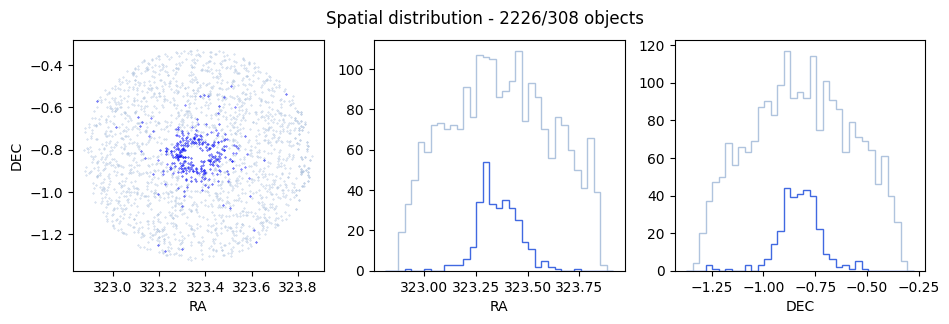

In [ ]:
# Create a figure with 3 subplots (ax1, ax2, ax3) in a single row
f, (ax1, ax2, ax3) = plt.subplots(1, 3)
f.set_size_inches(11, 3)  # Set figure size

# Calculate the number of field stars and Messier 2 stars
N = mask.sum()  # Total number of field stars passing the mask
N_M2 = M2_mask.sum()  # Total number of Messier 2 stars

# Set the overall title of the figure, showing the counts of selected objects
f.suptitle(f'Spatial distribution - {N}/{N_M2} objects')

# Extract right ascension (RA) and declination (DEC) from the dataset
ra = objects_table['RA_dr4']  # Right ascension
dec = objects_table['DEC_dr4']  # Declination

# Set up the RA and DEC ranges for plotting based on a given cone radius
x = cone_radius / 3600  # Convert cone radius from arcseconds to degrees
ra_range = cone_center_coord[0] + np.array([-1.1*x, 1.1*x])  # RA range based on cone radius
dec_range = cone_center_coord[1] + np.array([-1.1*x, 1.1*x])  # DEC range based on cone radius

im = ax1.scatter(ra[mask], dec[mask], c='lightsteelblue', s=0.1)
im = ax1.scatter(ra[M2_mask], dec[M2_mask], c='b', s=0.1)
ax1.set_xlabel('RA')
ax1.set_ylabel('DEC')
ax2.hist([ra[mask], ra[M2_mask]], bins=35, range=ra_range, density=False, color=['lightsteelblue', 'royalblue'], histtype='step')
ax2.set_xlabel('RA')
ax3.hist([dec[mask], dec[M2_mask]], bins=35, range=dec_range, density=False, color=['lightsteelblue', 'royalblue'], histtype='step')
ax3.set_xlabel('DEC')

## H.R. Diagrams 

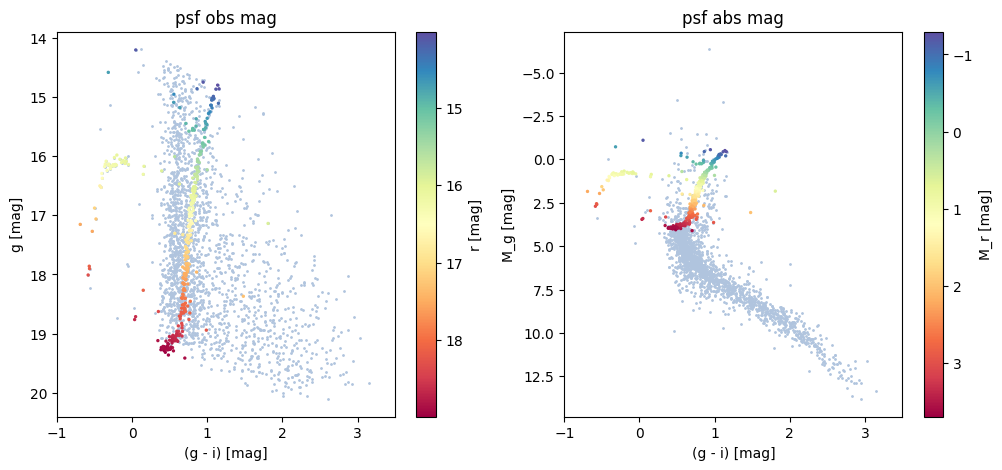

In [ ]:
# Calculate color (g - i) and magnitudes for plotting
x = objects_table[f'g_{apperture}{suffix}'] - objects_table[f'i_{apperture}{suffix}']  # Color index (g - i)
y = objects_table[f'g_{apperture}{suffix}']  # Magnitude in the g band
z = objects_table[f'r_{apperture}{suffix}']  # Magnitude in the r band (for color coding)

# Create two subplots side by side
f, (ax1, ax2) = plt.subplots(1, 2)
f.set_size_inches(12, 5)

# Scatter plot of observed magnitudes for field stars and Messier 2 stars
ax1.scatter(x[mask], y[mask], s=1, c='lightsteelblue')  # Field stars
sc = ax1.scatter(x[M2_mask], y[M2_mask], c=z[M2_mask], s=2, cmap='Spectral_r')  # Messier 2 stars
ax1.set_title(f'{apperture} obs mag')

# Add color bar for the r magnitude and set labels
cax = plt.colorbar(sc, ax=ax1)
cax.ax.set_ylabel('r [mag]')  # Color bar label for r magnitude
cax.ax.invert_yaxis()  # Invert color bar axis to follow astronomical convention

# Set x and y labels for the first plot
ax1.set_xlabel(f'(g - i) [mag]')  # Label x-axis as color (g - i)
ax1.set_ylabel(f'g [mag]')  # Label y-axis as g magnitude
ax1.set_xlim(-1, 3.5)  # Set limits for x-axis (g - i)
ax1.invert_yaxis()  # Invert y-axis for magnitude (smaller values = brighter stars)

# Convert field and Messier 2 magnitudes to absolute magnitudes using distance modulus correction
Y = y + mabs_corr  # Field stars' absolute magnitude
M2_Y = y + M2_mabs_corr  # Messier 2 stars' absolute magnitude
M2_Z = z + M2_mabs_corr  # Messier 2 corrected r magnitudes (for color)

# Scatter plot of absolute magnitudes for field and Messier 2 stars
ax2.scatter(x[mask & ~M2_mask], Y[mask & ~M2_mask], s=1, c='lightsteelblue')  # Field stars
sc = ax2.scatter(x[M2_mask], M2_Y[M2_mask], c=M2_Z[M2_mask], s=2, cmap='Spectral_r')  # Messier 2 stars
ax2.set_title(f'{apperture} abs mag')  # Set title for second plot

cax = plt.colorbar(sc, ax=ax2)
cax.ax.set_ylabel('M_r [mag]')
cax.ax.invert_yaxis()
ax2.set_xlabel(f'(g - i) [mag]')
ax2.set_ylabel(f'M_g [mag]')
ax2.set_xlim(-1, 3.5)
ax2.invert_yaxis()